# 1. Install Dependencies and Setup

In [2]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


Requested tensorflow-gpu from https://files.pythonhosted.org/packages/8a/45/fa31ced1db38f9424f262dfbf35747fe5378b5c808cecb373c8cb8e515d3/tensorflow-gpu-2.12.0.tar.gz has invalid metadata: Expected end or semicolon (after name and no valid version specifier)
    python_version>"3.7"
                  ^
Please use pip<24.1 if you need to use this version.
ERROR: Could not find a version that satisfies the requirement tensorflow-gpu (from versions: 2.12.0)

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for tensorflow-gpu


In [3]:
!pip list

Package                      Version
---------------------------- --------------
absl-py                      2.1.0
anyio                        4.4.0
argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
arrow                        1.3.0
asttokens                    2.4.1
astunparse                   1.6.3
async-lru                    2.0.4
attrs                        24.2.0
babel                        2.16.0
beautifulsoup4               4.12.3
bleach                       6.1.0
certifi                      2024.7.4
cffi                         1.17.0
charset-normalizer           3.3.2
colorama                     0.4.6
comm                         0.2.2
contourpy                    1.2.1
cycler                       0.12.1
debugpy                      1.8.5
decorator                    5.1.1
defusedxml                   0.7.1
executing                    2.0.1
fastjsonschema               2.20.0
flatbuffers                  24.3.25
fonttools                    4.

In [4]:
import tensorflow as tf
import os

In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [7]:
import cv2
import imghdr

C:\Users\sagar\AppData\Local\Temp\ipykernel_11036\4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [8]:
data_dir = 'data' 

In [9]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [10]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [11]:
import numpy as np
from matplotlib import pyplot as plt

In [12]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [13]:
data_iterator = data.as_numpy_iterator()

In [14]:
batch = data_iterator.next()

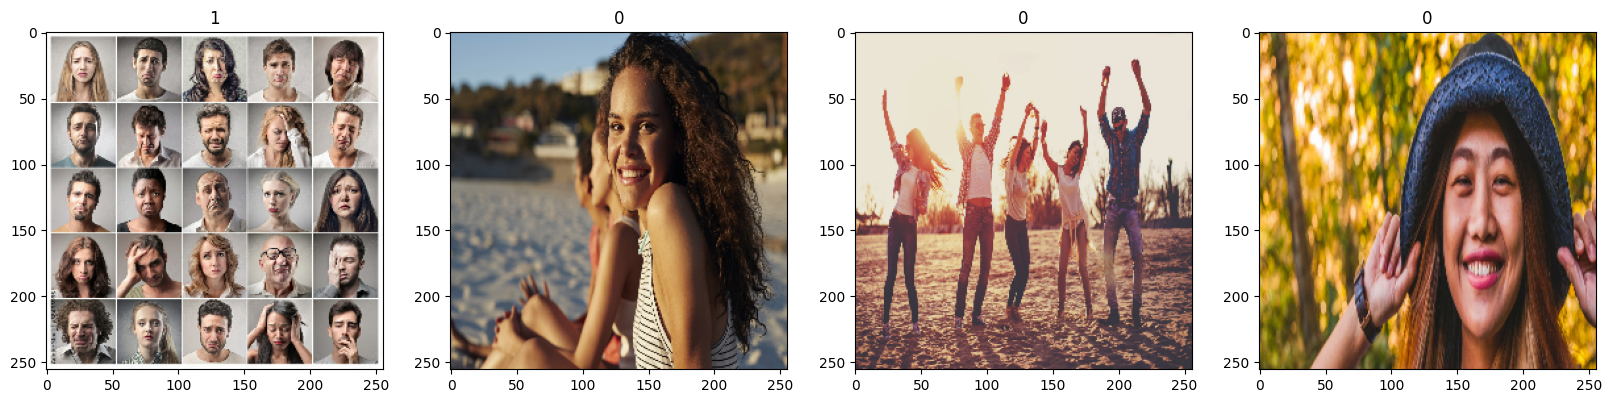

In [15]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [16]:
data = data.map(lambda x,y: (x/255, y))

In [17]:
data.as_numpy_iterator().next()

(array([[[[0.05098039, 0.04313726, 0.04705882],
          [0.05199142, 0.04414828, 0.04806985],
          [0.05658701, 0.04874387, 0.05266544],
          ...,
          [0.2963848 , 0.3356005 , 0.34344363],
          [0.26590073, 0.30511642, 0.31295955],
          [0.24806985, 0.28728554, 0.29512867]],
 
         [[0.05098039, 0.04313726, 0.04705882],
          [0.05199142, 0.04414828, 0.04806985],
          [0.05658701, 0.04874387, 0.05266544],
          ...,
          [0.2944853 , 0.33370098, 0.34154412],
          [0.26400122, 0.3032169 , 0.31106004],
          [0.24617034, 0.28538603, 0.29322916]],
 
         [[0.05098039, 0.04313726, 0.04705882],
          [0.05199142, 0.04414828, 0.04806985],
          [0.05658701, 0.04874387, 0.05266544],
          ...,
          [0.2913603 , 0.33057597, 0.3384191 ],
          [0.26087624, 0.30009192, 0.30793506],
          [0.24304534, 0.28226104, 0.29010418]],
 
         ...,
 
         [[0.02745098, 0.05098039, 0.03529412],
          [0.02745

# 5. Split Data

In [18]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [19]:
train_size

7

In [20]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [21]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [23]:
model = Sequential()

In [24]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

c:\Users\sagar\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# 7. Train

In [27]:
logdir='logs'

In [28]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [29]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 327ms/step - accuracy: 0.5680 - loss: 1.1837 - val_accuracy: 0.5781 - val_loss: 0.6749
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 321ms/step - accuracy: 0.6647 - loss: 0.6720 - val_accuracy: 0.5781 - val_loss: 0.6508
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 297ms/step - accuracy: 0.6355 - loss: 0.6240 - val_accuracy: 0.7656 - val_loss: 0.5161
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 307ms/step - accuracy: 0.8480 - loss: 0.4729 - val_accuracy: 0.7812 - val_loss: 0.4611
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 326ms/step - accuracy: 0.8253 - loss: 0.4026 - val_accuracy: 0.9219 - val_loss: 0.2615
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 310ms/step - accuracy: 0.9138 - loss: 0.2753 - val_accuracy: 0.9531 - val_loss: 0.1696
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 334ms/step - accuracy: 0.9313 - loss: 0.2143 - val_accuracy: 0.9531 - val_loss: 0.1193
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 304ms/step - accuracy: 0.9694 - loss: 0.1394 - val_accuracy: 0.9531 - val_loss:

# 8. Plot Performance

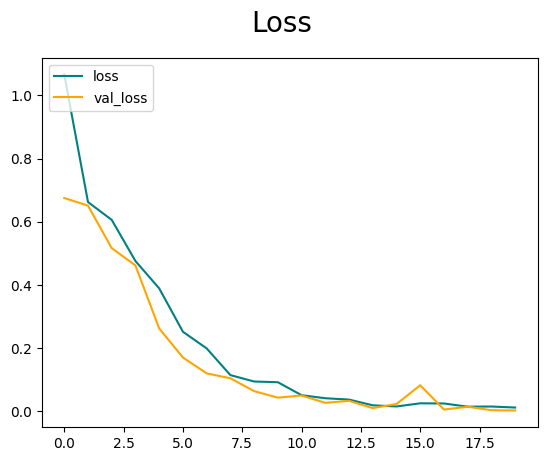

In [30]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

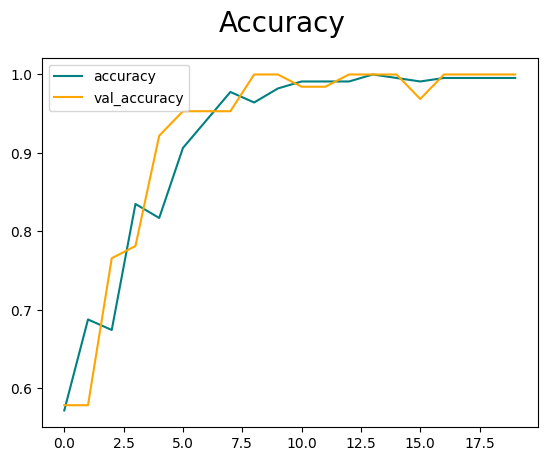

In [31]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [32]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [33]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [34]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


In [35]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.90909094, shape=(), dtype=float32) tf.Tensor(0.9411765, shape=(), dtype=float32)


# 10. Test

In [36]:
import cv2

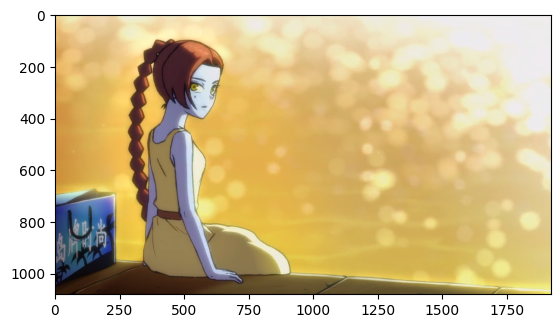

In [37]:
img = cv2.imread('Screenshot (103).png')
plt.imshow(img)
plt.show()

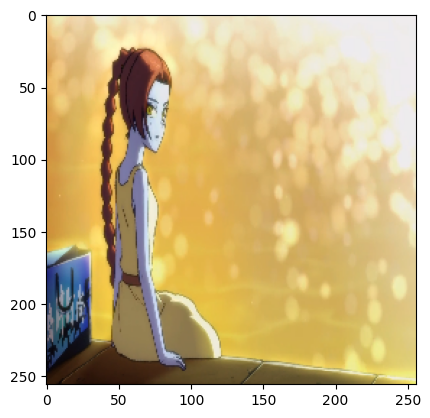

In [38]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [39]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


In [40]:
yhat

array([[0.4105589]], dtype=float32)

In [41]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


# 11. Save the Model

In [42]:
from tensorflow.keras.models import load_model

In [43]:
model.save(os.path.join('models','imageclassifier.h5'))

In [44]:
new_model = load_model("H:\sem 7 project\image classification\ImageClassification-main\ImageClassification-main\models\imageclassifier.h5")

In [45]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


array([[0.4105589]], dtype=float32)